# Predicting sport specific performance from field testing in synchronized swimming
Romain Martinez ([GitHub](https://github.com/romainmartinez))

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
NORMALIZE = 'False'

## Get the data

In [3]:
DATA_PATH = Path("./data/zTable.xlsx")
df = pd.read_excel(DATA_PATH)

df.head()

,Name,Height,Weight,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,...,FLEX/D,EB max force,EB mean force,EB sd force,EB max height,EB min height,EB mean height,EB sd height,EB max-min height,BB
0,'aissatou_sougou',1.69,48.52,287.05,285.00,206.85,179.90,92.85,94.95,52.3,...,146.00,8.33,6.770000,0.439447,8.5,7.5,8.083333,0.376386,1.0,9.5
1,'anais_charland',1.63,62.13,292.75,302.75,239.85,207.85,109.25,103.25,98.4,...,123.35,9.43,7.762753,0.584721,7.5,7.0,7.083333,0.204124,0.5,8.5
2,'anne sophie_moreau',1.71,54.90,252.40,258.55,233.45,233.65,69.30,68.80,120.0,...,204.80,8.76,6.725683,0.767079,8.0,7.5,7.833333,0.258199,0.5,8.5
3,'audrey_lamothe',1.50,43.44,213.45,227.40,174.00,132.10,54.20,56.40,39.9,...,112.25,9.86,7.315823,0.815853,8.0,7.0,7.416667,0.376386,1.0,8.5
4,'billie_francis',1.78,62.04,281.75,296.20,258.65,227.25,97.25,99.05,77.2,...,152.85,10.77,8.995158,0.570680,7.5,7.0,7.333333,0.258199,0.5,9.0


In [4]:
# variables
variables = [
    "ADD/G",
    "ADD/D",
    "ABD/G",
    "ABD/D",
    "ER/G",
    "ER/D",
    "IR/G",
    "IR/D",
    "EXT/G",
    "EXT/D",
    "FLEX/G",
    "FLEX/D",
]
X = df[variables] / 9.81
X.head()

,ADD/G,ADD/D,ABD/G,ABD/D,ER/G,ER/D,IR/G,IR/D,EXT/G,EXT/D,FLEX/G,FLEX/D
0,29.260958,29.051988,21.085627,18.338430,9.464832,9.678899,5.331295,5.295617,16.987768,20.050968,18.654434,14.882773
1,29.841998,30.861366,24.449541,21.187564,11.136595,10.524975,10.030581,8.567788,31.396534,26.243629,15.963303,12.573904
2,25.728848,26.355759,23.797146,23.817533,7.064220,7.013252,12.232416,12.212029,14.383282,11.539246,20.341488,20.876656
3,21.758410,23.180428,17.737003,13.465851,5.524975,5.749235,4.067278,3.792049,14.123344,0.203874,12.003058,11.442406
4,28.720693,30.193680,26.365953,23.165138,9.913354,10.096840,7.869521,6.365953,21.116208,17.018349,16.156983,15.581040


In [5]:
targets = ["BB", "EB mean height", "EB mean force"]
y = df[targets].rename(
    columns={"BB": "BB-H", "EB mean height": "EB-H", "EB mean force": "EB-F"}
)
y.head()

,BB-H,EB-H,EB-F
0,9.5,8.083333,6.770000
1,8.5,7.083333,7.762753
2,8.5,7.833333,6.725683
3,8.5,7.416667,7.315823
4,9.0,7.333333,8.995158


## Normalize data
We should normalize the field tests (`X`) by anthropometric measurements.

In [6]:
if NORMALIZE == "weight":
    normalizer = df["Weight"]
elif NORMALIZE == "IMC":
    normalizer = df["Weight"] / df["Height"] ** 2
elif NORMALIZE == "weight-height":
    normalizer = df["Weight"] * df["Height"]
else:
    normalizer = 1
    print("data not normalized")
X = X.divide(normalizer, axis=0)

data not normalized


## NaN remover

In [7]:
nan_id = np.argwhere(np.isnan(X.values))
for i in nan_id:
    print(f'participant no.: {i[0]}')
    print(f'\ttest: {X.columns[i[1]]}')
    # if left take right, left otherwise
    if X.columns[i[1]][-1] == 'G':
        replacer = i[1] + 1
    else:
        replacer = i[1] - 1
    print(f'\t\t"{X.iloc[i[0], i[1]]}" replace by "{X.iloc[i[0], replacer]}"')
    X.at[i[0], X.columns[i[1]]] = X.at[i[0], X.columns[replacer]]

participant no.: 5
	test: ADD/D
		"nan" replace by "32.95107033639144"
participant no.: 41
	test: IR/G
		"nan" replace by "12.125382262996942"
participant no.: 90
	test: IR/G
		"nan" replace by "9.403669724770642"


## Data description

### Variables $X$
Hip strength tests (field testing):
- `ADD`: adduction test
- `ABD`: abduction test
- `ER`: external rotation test
- `IR`: internal rotation test
- `EXT`: extension test
- `FLEX`: flexion test

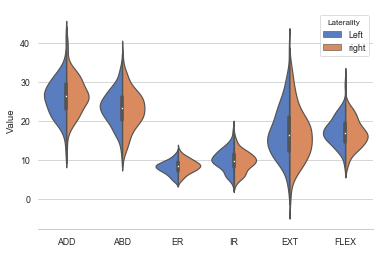

In [8]:
v = sns.violinplot(
    x="test",
    y="value",
    hue="Laterality",
    split=True,
    inner="box",
    scale="count",
    palette="muted",
    data=X.melt().assign(
        test=lambda x: x["variable"].str.split("/").str[0],
        Laterality=lambda x: x["variable"]
        .str.split("/")
        .str[1]
        .replace({"D": "right", "G": "Left"}),
    ),
)
v.set(xlabel="", ylabel="Value")
sns.despine(left=True)


v.figure.savefig("./share/fig/X.png", dpi=300)

### Targets $y$

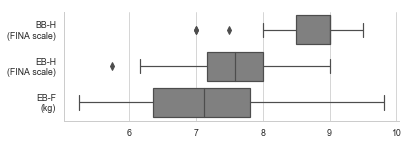

In [9]:
# v = sns.violinplot(scale="count", split=True, color="grey", inner="box", data=y)
plt.figure(figsize=(6, 2))
v = sns.boxplot(color="grey", orient='h', data=y)
v.set(
    xlabel="",
    ylabel="",
    yticklabels=["BB-H\n(FINA scale)", "EB-H\n(FINA scale)", "EB-F\n(kg)"],
)
sns.despine()
plt.savefig('./share/fig/y.png', dpi=300)

## Add features

### Fscore
Let's try to transform each *left* and *right* tests into a single "Fscore" such as:
$$F_{\text{score}} = 2 \times \frac{\text{left} \times \text{right}}{\text{left} + \text{right}}$$

This formula favors left & right tests that are similar and therefore penalizes asymmetries.

In [10]:
def f_score(a, b):
    """Takes two columns and compute the F score."""
    return 2 * (a * b) / (a + b)

### Imbalance

In [11]:
def imbalance(a, b):
    """compute the imbalance score, in percentage."""
    return np.abs((a - b) / a) * 100

In [12]:
X_augmented = pd.DataFrame()
for name, icol in X.iteritems():
    b = np.empty(0)
    if name[-1] == 'G':
        a = icol
    else:
        b = icol
    if b.any():
        X_augmented[name[:-2]] = f_score(a, b)
        X_augmented[f'imb_{name[:-2]}'] = imbalance(a, b)

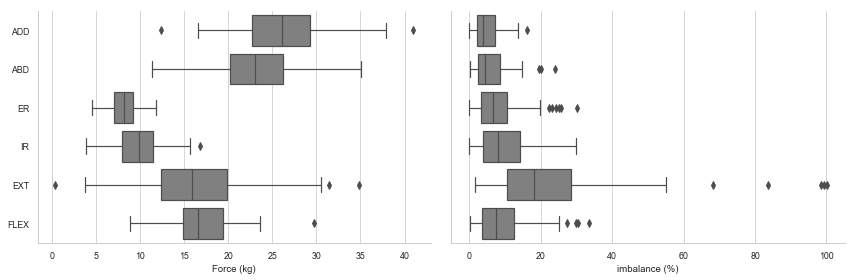

In [13]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] == "i"]],
    orient="h",
    color="grey",
    ax=ax[1],
)
sns.boxplot(
    data=X_augmented[[i for i in X_augmented if i[0] != "i"]],
    orient="h",
    color="grey",
    ax=ax[0],
)
ax[0].set_xlabel("Force (kg)")
ax[1].set_xlabel("imbalance (%)")
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/X.png', dpi=300)

## Fitting an ensemble model

In [14]:
X_augmented['Height'] = df['Height']
X_augmented['Weight'] = df['Weight']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y, test_size=0.2, random_state=RANDOM_SEED
)

### Helper functions

In [16]:
from sklearn.metrics import mean_squared_error


def mape(y_test, y_pred):
    return (np.abs((y_test - y_pred) / y_test)) * 100


def mae(y_test, y_pred):
    return np.abs(y_test - y_pred)


def evaluate(y_test, y_pred):
    d = {"mae": mae(y_test, y_pred), "mape": mape(y_test, y_pred)}
    print(
        f"""
    \tmae = {d['mae'].mean():.3f} ({d['mae'].std():.3f})
    \tmape = {d['mape'].mean():.3f}% ({d['mape'].std():.3f})
    """
    )
    return d

In [17]:
# from skopt import BayesSearchCV, dump, load


# class BayesSearch:
#     def __init__(self, model, search_spaces, n_iter, export_path):
#         self.export_path = export_path
#         self.bayes_cv_tuner = BayesSearchCV(
#             model,
#             search_spaces,
#             cv=5,
#             n_jobs=-1,
#             n_iter=n_iter,
#             verbose=0,
#             refit=True,
#             random_state=RANDOM_SEED,
#         )

#     def fit(self, X, y):
#         self.bayes_cv_tuner.fit(X, y, callback=self.print_status)
#         self.export_results()

#     def export_results(self):
#         pd.DataFrame(self.bayes_cv_tuner.cv_results_).to_csv(
#             f"{self.export_path}_cv_results.csv"
#         )
#         pd.Series(self.bayes_cv_tuner.best_params_).to_json(
#             f"{self.export_path}_best_params.json"
#         )
#         dump(self.bayes_cv_tuner, f"{self.export_path}_bayes_search.pkl")

#     def print_status(self, optim_results):
#         print(
#             f"""
# Model #{len(opt.bayes_cv_tuner.cv_results_['params'])}
# Best: {self.bayes_cv_tuner.best_score_}
# Best params: {self.bayes_cv_tuner.best_params_}
#         """
#         )

### Fit model

In [18]:
from xgboost import XGBRegressor

OPT = False
ITERATIONS = 100

params = {"n_jobs": 1, "silent": 1, "tree_method": "approx"}

if OPT:
    for itarget in y.columns:
        OPT_EXPORT = f"opt/{itarget}"

        search_spaces = {
            "learning_rate": (0.01, 1.0, "log-uniform"),
            "min_child_weight": (0, 10),
            "max_depth": (0, 50),
            "max_delta_step": (0, 20),
            "subsample": (0.01, 1.0, "uniform"),
            "colsample_bytree": (0.01, 1.0, "uniform"),
            "colsample_bylevel": (0.01, 1.0, "uniform"),
            "reg_lambda": (1e-9, 1000, "log-uniform"),
            "reg_alpha": (1e-9, 1.0, "log-uniform"),
            "gamma": (1e-9, 0.5, "log-uniform"),
            "min_child_weight": (0, 5),
            "n_estimators": (50, 100),
            "scale_pos_weight": (1e-6, 500, "log-uniform"),
        }

        opt = BayesSearch(
            model=XGBRegressor(**params),
            search_spaces=search_spaces,
            n_iter=ITERATIONS,
            export_path=OPT_EXPORT,
        )
        opt.fit(X_train, y_train[itarget])

In [19]:
USE_OPT = False

boosted = {}
evaluation = {}

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)

for itarget, itarget_name in enumerate(y_train.columns):
    print(f"\t{itarget}. {itarget_name}\n")

    opt_params = (
        load(f"opt/{itarget_name}_bayes_search.pkl").best_params_ if USE_OPT else {}
    )

    boosted[itarget_name] = XGBRegressor(
        **{**params, **opt_params}, random_state=RANDOM_SEED
    )
    boosted[itarget_name].fit(
        X_train,
        y_train[itarget_name],
        eval_set=[(X_train, y_train[itarget_name]), (X_test, y_test[itarget_name])],
        early_stopping_rounds=50,
        eval_metric="rmse",
        verbose=50,
    )

    evaluation[itarget_name] = evaluate(
        y_test[itarget_name], boosted[itarget_name].predict(X_test)
    )
    evaluation[itarget_name]["test"] = [
        itarget_name for i in range(len(evaluation[itarget_name]["mae"]))
    ]

    print(f'{"-" * 30}\n')
evaluation = pd.concat([pd.DataFrame(evaluation[itest]) for itest in evaluation.keys()])

	0. BB-H

[0]	validation_0-rmse:7.41009	validation_1-rmse:7.61465
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.20484	validation_1-rmse:0.624062
[99]	validation_0-rmse:0.07597	validation_1-rmse:0.580138

    	mae = 0.518 (0.267)
    	mape = 5.853% (3.063)
    
------------------------------

	1. EB-H

[0]	validation_0-rmse:6.40972	validation_1-rmse:6.18042
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[50]	validation_0-rmse:0.187028	validation_1-rmse:0.55857
Stopping. Best iteration:
[44]	validation_0-rmse:0.229892	validation_1-rmse:0.555945


    	mae = 0.437 (0.353)
    	mape = 6.187% (5.566)
    
------------------------------

	2. EB-F

[0]	validation_0-rmse:6.04267	validation_1-rmse:6.33821
Multiple eval metrics have been passed: 'val

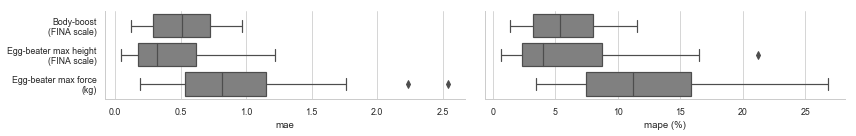

In [20]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 2))
sns.boxplot(y="test", x="mae", data=evaluation, ax=ax[0], orient="h", color="grey")
sns.boxplot(y="test", x="mape", data=evaluation, ax=ax[1], orient="h", color="grey")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[1].set_xlabel("mape (%)")
# TODO: %

ax[0].set_yticklabels(
    [
        "Body-boost\n(FINA scale)",
        "Egg-beater max height\n(FINA scale)",
        "Egg-beater max force\n(kg)",
    ]
)
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/eval.png', dpi=300)

In [21]:
evaluation.groupby('test').mean()['mape'].sum()

24.56533763404073

## Interpretation

In [22]:
import shap

shap.initjs()

explainer = {itarget: shap.TreeExplainer(boosted[itarget]) for itarget in y.columns}
shap_values = {
    itarget: explainer[itarget].shap_values(X_augmented) for itarget in y.columns
}

### How important are our features?
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample.

The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output.

In [23]:
shap_df = pd.concat(
    [
        pd.DataFrame(shap_values[i], columns=X_train.columns).assign(target=i)
        for i in y.columns
    ]
)

In [24]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()

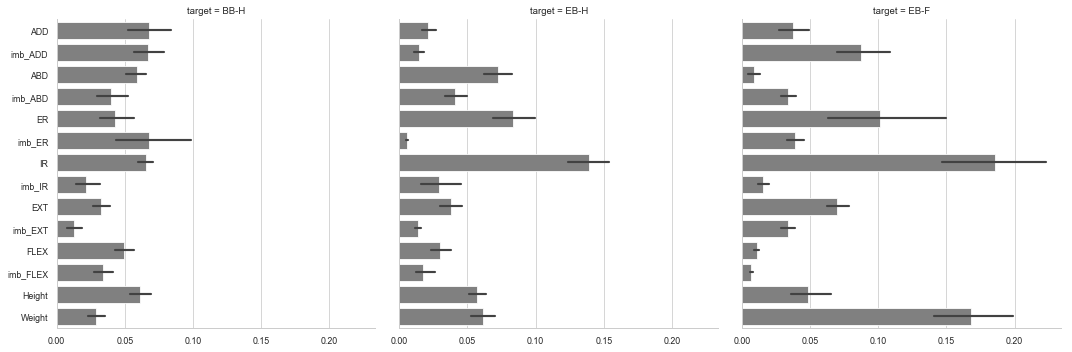

In [25]:
shap_df_abs = shap_df.copy()
shap_df_abs[X_train.columns] = shap_df_abs[X_train.columns].abs()
sns.catplot(col="target", data=shap_df_abs, color="grey", kind="bar", orient="h")

sns.despine()

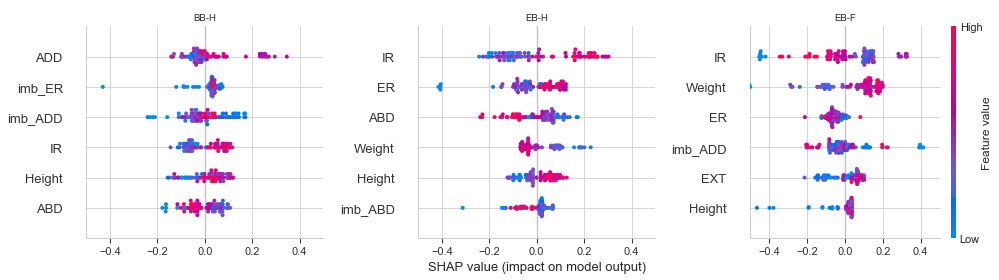

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
MAX_DISPLAY = 6

for i, itarget in enumerate(y.columns):
    color_bar = True if i == 2 else False

    plt.sca(ax[i])
    shap.summary_plot(
        shap_values[itarget],
        X_augmented,
        show=False,
        color_bar=color_bar,
        auto_size_plot=False,
        max_display=MAX_DISPLAY,
        plot_type="dot",
    )
    ax[i].set_title(itarget)
    ax[i].set_xlim(-0.5, 0.5)
    if i != 1:
        ax[i].set_xlabel("")
plt.tight_layout()
sns.despine()
plt.savefig('./share/fig/shap.png', dpi=300)

### What is the prediction path?
The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [27]:
random_observation = np.random.randint(0, X_augmented.shape[0])

itarget = y.columns[0]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset

In [28]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [29]:
shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

In [30]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

In [31]:
itarget = targets[2]

shap.force_plot(explainer[itarget].expected_value,
                shap_values[itarget][random_observation, :],
                X_augmented.iloc[random_observation, :])

KeyError: 'EB mean force'

In [32]:
shap.force_plot(explainer[itarget].expected_value, shap_values[itarget], X_augmented)

KeyError: 'EB mean force'

### How is target variable related with important features?
The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all observations we can see how changes in the feature's value effect the model's output.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset.

Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in fatigue as AveShEleMean changes.

Vertical dispersion at a single value of AveShEleMean represents interaction effects with other features.

To help reveal these interactions dependence_plot automatically selects another feature for coloring.

In this case coloring by ROMTrYMean highlights that AveShEleMean has less impact on fatigue when ROMTrXMean decreases and conversely.

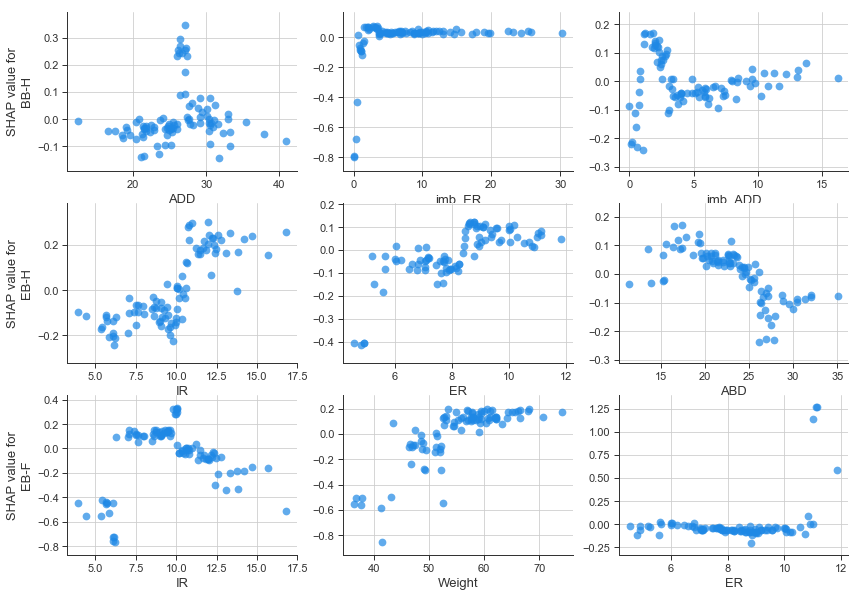

In [33]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14, 10))

for irow, itarget in enumerate(y.columns):
    # sort the features indexes by their importance in the model
    # (sum of SHAP value magnitudes over the validation dataset)
    top_inds = np.argsort(-np.sum(np.abs(shap_values[itarget]), axis=0))

    # make SHAP plots of the three most important features and their best interaction
    for icol, idx in enumerate(top_inds[:3]):
        plt.sca(ax[irow, icol])

        shap.dependence_plot(
            idx,
            shap_values[itarget],
            X_augmented,
            dot_size=60,
            interaction_index=None,
            alpha=0.7,
            show=False,
        )
        ax[irow, icol].set_ylabel("")
    ax[irow, 0].set_ylabel(f"SHAP value for\n{itarget}")

plt.gcf().set_size_inches(14, 10)
sns.despine()

### Supervised clustering
Clustering people by their shap values leads to groups relevent to the prediction task at hand.

In [47]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
itarget = y.columns[0]

shap_pca2 = PCA(n_components=2).fit_transform(shap_values[itarget][:, :-1])
shap_embedded = TSNE(
    n_components=2, perplexity=50).fit_transform(shap_values[itarget][:, :-1])

In [50]:
def plot_clusters(x, y, c, label, a):
    a.scatter(
        x, y, c=c, linewidth=0, alpha=0.8, s=60)
    PCM=a.get_children()[0]
    cb = plt.colorbar(PCM, label=label, aspect=40, orientation="horizontal", ax=a)
    cb.set_alpha(1)
    cb.draw_all()
    cb.outline.set_linewidth(0)
    cb.ax.tick_params('x', length=0)
    cb.ax.xaxis.set_label_position('top')
    a.axis("off")

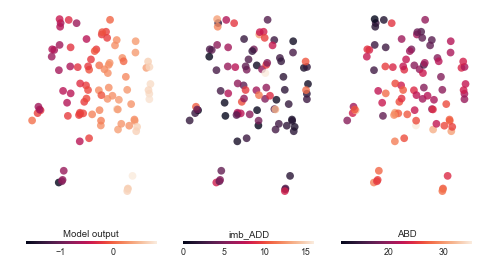

In [51]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,5))

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=np.sum(shap_values[itarget], axis=1),
    a=ax[0],
    label='Model output')

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][0]],
    a=ax[1],
    label=feature_importance[itarget][0])

plot_clusters(
    x=shap_embedded[:, 0],
    y=shap_embedded[:, 1],
    c=X_augmented[feature_importance[itarget][1]],
    a=ax[2],
    label=feature_importance[itarget][1])

plt.show()